To prepare a dataset suitable for a mixed-effects model in R, I'll follow these steps:

- Start by processing individual data files:
  - Exclude days with incomplete data between the first and last day, as these gaps could introduce biases (the missing data is not random which isn't suitable for mixed effects modelling).
  -remove days column (reasoning provided in eda.ipynb file). remove afftype and melanch to maintain simplicity in analysis. They're both depression types and can later be factored in to add more nuance. 
  -include other relevant cleaning of data (similar to how I did in eda.ipynb)
  - Remove days where the average actigraph activity falls below 10 units, as these may indicate insufficient data quality or participant compliance.
  - Introduce a new column to represent each minute of the day (from 1 to 1440) and day (1 to number of days recorded per individual), enhancing the interpretability of our model's results.
  - Merge information from the "score.csv" file, linking data based on the individual being studied. For consistency and clarity, we'll create a long-format dataset, duplicating time-invariant covariate data (such as gender, age, and depression scores) across all rows.

Once individual files are processed, save them separately. Then, merge these individual files into a single comprehensive dataset.

Finally, create a "group" column to distinguish between condition and control groups, ensuring that each individual's group membership is accurately represented in the dataset.

In [1]:
import numpy as np
import pandas as pd

data_path= 'C:/Users/anshi/Downloads/depression/data/'
score= pd.read_csv(data_path + 'scores.csv')

C:\Users\anshi\AppData\Local\Temp\ipykernel_8772\873534339.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
score = score.replace(' ', np.nan)
score.replace('NaN', np.nan, inplace=True)
score[['start_age', 'end_age']]=score['age'].str.extract(r'(\d+)-(\d+)').astype(int)
score[['start_edu', 'end_edu']]=score['edu'].str.extract(r'(\d+)-(\d+)').astype('Int64')
score['avg_age']=score[['start_age', 'end_age']].mean(axis=1)
score['avg_age']=score['avg_age'].astype(int)
score['avg_edu']=score[['start_edu', 'end_edu']].mean(axis=1)
score['avg_edu']=score['avg_edu'].astype(float)
score['avg_madrs'] = score[['madrs1', 'madrs2']].mean(axis=1)
score['delta_madrs'] = score['madrs2'] - score['madrs1']
score = score.drop(['days','afftype', 'edu','melanch','start_age', 'end_age', 'age', 'start_edu', 'end_edu'], axis=1)



In [10]:
all_condition=pd.DataFrame()


for i in range(1,24):
    condition= pd.read_csv(data_path + f'condition/condition_{i}.csv')

    condition_bydate = condition.groupby(['date'], as_index=False).agg(
        n=pd.NamedAgg(column='activity', aggfunc='count'),
        mean_activity=pd.NamedAgg(column='activity', aggfunc='mean')
    )
#removing days with irrationally low average daily activity. 
    condition_bydate= condition_bydate[condition_bydate.mean_activity>10]
    condition_bydate = condition_bydate[(condition_bydate.index==0) | (condition_bydate.n==1440) | (condition_bydate.index== len(condition_bydate)-1)]
    mask = condition['date'].isin(condition_bydate['date'])
    condition=condition[mask]
    condition = condition.dropna(subset=['timestamp'])

# Reset the index after dropping rows
    condition.reset_index(drop=True, inplace=True)

    condition['minute'] = condition.groupby('date').cumcount() + 1
    condition['day'] = condition.groupby('date').ngroup() + 1

    group = score[score['number']==f'condition_{i}']
    group = pd.concat([group] * len(condition), ignore_index=True)
    condition = pd.concat([condition, group], axis=1)

    if i==1:
        all_condition=condition
    else:
        all_condition= pd.concat([all_condition, condition], axis=0)
    
    #print(f'condition {i}')
    #print(condition)



In [12]:
all_condition

,timestamp,date,activity,minute,day,number,gender,inpatient,marriage,work,madrs1,madrs2,avg_age,avg_edu,avg_madrs,delta_madrs
0,2003-05-07 12:00:00,2003-05-07,0,1,1,condition_1,2,2.0,1.0,2.0,19.0,19.0,37,8.0,19.0,0.0
1,2003-05-07 12:01:00,2003-05-07,143,2,1,condition_1,2,2.0,1.0,2.0,19.0,19.0,37,8.0,19.0,0.0
2,2003-05-07 12:02:00,2003-05-07,0,3,1,condition_1,2,2.0,1.0,2.0,19.0,19.0,37,8.0,19.0,0.0
3,2003-05-07 12:03:00,2003-05-07,20,4,1,condition_1,2,2.0,1.0,2.0,19.0,19.0,37,8.0,19.0,0.0
4,2003-05-07 12:04:00,2003-05-07,166,5,1,condition_1,2,2.0,1.0,2.0,19.0,19.0,37,8.0,19.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25135,2002-06-23 23:55:00,2002-06-23,0,1436,18,condition_23,1,1.0,2.0,2.0,29.0,23.0,32,18.0,26.0,-6.0
25136,2002-06-23 23:56:00,2002-06-23,0,1437,18,condition_23,1,1.0,2.0,2.0,29.0,23.0,32,18.0,26.0,-6.0
25137,2002-06-23 23:57:00,2002-06-23,0,1438,18,condition_23,1,1.0,2.0,2.0,29.0,23.0,32,18.0,26.0,-6.0
25138,2002-06-23 23:58:00,2002-06-23,0,1439,18,condition_23,1,1.0,2.0,2.0,29.0,23.0,32,18.0,26.0,-6.0


In [13]:
import pandas as pd

# Load the data into a pandas DataFrame

# Define a function to segment the minute feature dynamically based on the midpoint
def minute_segment(row, midpoints):
    midpoint = midpoints.get((row['number'], row['date']), 0)
    return 'first_half' if row['minute'] <= midpoint else 'second_half'

# Calculate the midpoint for each participant and each day
midpoints = all_condition.groupby(['number', 'date'])['minute'].max() // 2
midpoints = midpoints.to_dict()

# Apply the function to create a new segment column
all_condition['minute_segment'] = all_condition.apply(lambda row: minute_segment(row, midpoints), axis=1)

# Group by 'number', 'date', and 'minute_segment' to calculate the mean activity for each segment
agg_data = all_condition.groupby(['number', 'date', 'minute_segment'])['activity'].mean().reset_index()

# Pivot the data to have separate columns for the two segments
agg_data_pivot = agg_data.pivot_table(index=['number', 'date'], columns='minute_segment', values='activity').reset_index()

# Rename columns for clarity
agg_data_pivot.columns = ['number', 'date', 'mean_activity_first_half', 'mean_activity_second_half']

# Merge the aggregated data back to the original DataFrame
all_condition = pd.merge(all_condition, agg_data_pivot, on=['number', 'date'], how='left')

# Create a new column that retains mean_activity_first_half if minute_segment is 'first_half', otherwise mean_activity_second_half
all_condition['mean_activity_segment'] = all_condition.apply(
    lambda row: row['mean_activity_first_half'] if row['minute_segment'] == 'first_half' else row['mean_activity_second_half'], axis=1
)

all_condition['log_mean_activity_segment'] = np.log(all_condition['mean_activity_segment']+0.01)


In [29]:
all_condition

,timestamp,date,activity,minute,day,number,gender,inpatient,marriage,work,...,madrs2,avg_age,avg_edu,avg_madrs,delta_madrs,minute_segment,mean_activity_first_half,mean_activity_second_half,mean_activity_segment,log_mean_activity_segment
0,2003-05-07 12:00:00,2003-05-07,0,1,1,condition_1,2,2.0,1.0,2.0,...,19.0,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865
1,2003-05-07 12:01:00,2003-05-07,143,2,1,condition_1,2,2.0,1.0,2.0,...,19.0,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865
2,2003-05-07 12:02:00,2003-05-07,0,3,1,condition_1,2,2.0,1.0,2.0,...,19.0,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865
3,2003-05-07 12:03:00,2003-05-07,20,4,1,condition_1,2,2.0,1.0,2.0,...,19.0,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865
4,2003-05-07 12:04:00,2003-05-07,166,5,1,condition_1,2,2.0,1.0,2.0,...,19.0,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501042,2002-06-23 23:55:00,2002-06-23,0,1436,18,condition_23,1,1.0,2.0,2.0,...,23.0,32,18.0,26.0,-6.0,second_half,48.043056,265.661111,265.661111,5.582259
501043,2002-06-23 23:56:00,2002-06-23,0,1437,18,condition_23,1,1.0,2.0,2.0,...,23.0,32,18.0,26.0,-6.0,second_half,48.043056,265.661111,265.661111,5.582259
501044,2002-06-23 23:57:00,2002-06-23,0,1438,18,condition_23,1,1.0,2.0,2.0,...,23.0,32,18.0,26.0,-6.0,second_half,48.043056,265.661111,265.661111,5.582259
501045,2002-06-23 23:58:00,2002-06-23,0,1439,18,condition_23,1,1.0,2.0,2.0,...,23.0,32,18.0,26.0,-6.0,second_half,48.043056,265.661111,265.661111,5.582259


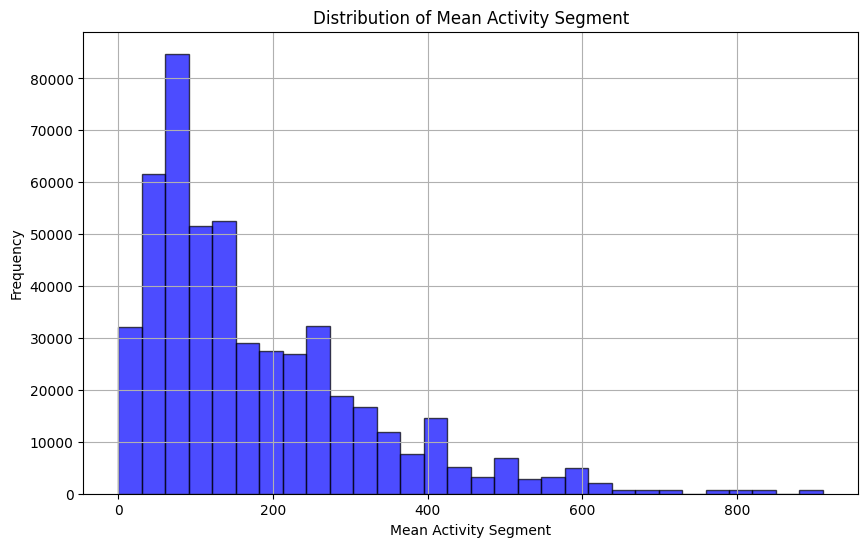

In [25]:
import matplotlib.pyplot as plt

# Plotting the distribution of mean_activity_segment using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(all_condition['mean_activity_segment'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Mean Activity Segment')
plt.xlabel('Mean Activity Segment')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

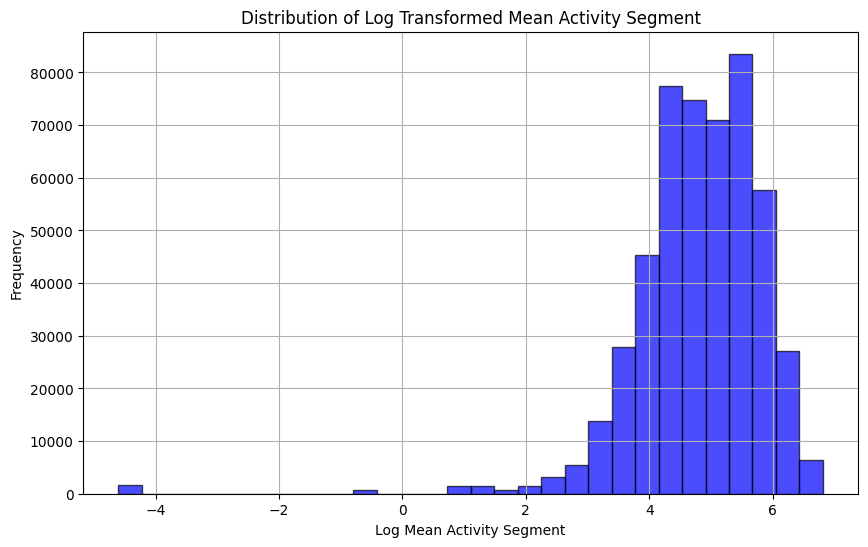

In [28]:
all_condition['log_mean_activity_segment'] = np.log(all_condition['mean_activity_segment']+0.01)

# Plotting the distribution of log_mean_activity_segment using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(all_condition['log_mean_activity_segment'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Log Transformed Mean Activity Segment')
plt.xlabel('Log Mean Activity Segment')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [42]:
all_control

,timestamp,date,activity,minute,day,number,gender,inpatient,marriage,work,...,avg_age,avg_edu,avg_madrs,delta_madrs,minute_segment,mean_activity_first_half,mean_activity_second_half,mean_activity_segment,log_mean_activity_segment,sqrt_mean_activity_segment
0,2003-03-18 15:00:00,2003-03-18,60,1,1,control_1,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,first_half,536.388889,240.929630,536.388889,6.284878,23.160287
1,2003-03-18 15:01:00,2003-03-18,0,2,1,control_1,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,first_half,536.388889,240.929630,536.388889,6.284878,23.160287
2,2003-03-18 15:02:00,2003-03-18,264,3,1,control_1,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,first_half,536.388889,240.929630,536.388889,6.284878,23.160287
3,2003-03-18 15:03:00,2003-03-18,662,4,1,control_1,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,first_half,536.388889,240.929630,536.388889,6.284878,23.160287
4,2003-03-18 15:04:00,2003-03-18,293,5,1,control_1,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,first_half,536.388889,240.929630,536.388889,6.284878,23.160287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714326,2003-04-04 23:55:00,2003-04-04,0,1436,15,control_32,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,second_half,73.658333,3.159722,3.159722,1.153644,1.780371
714327,2003-04-04 23:56:00,2003-04-04,0,1437,15,control_32,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,second_half,73.658333,3.159722,3.159722,1.153644,1.780371
714328,2003-04-04 23:57:00,2003-04-04,0,1438,15,control_32,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,second_half,73.658333,3.159722,3.159722,1.153644,1.780371
714329,2003-04-04 23:58:00,2003-04-04,0,1439,15,control_32,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,second_half,73.658333,3.159722,3.159722,1.153644,1.780371


In [30]:
all_control = pd.DataFrame()
 
for i in range(1,33):

    control= pd.read_csv(data_path + f'control/control_{i}.csv')

    control_bydate = control.groupby(['date'], as_index=False).agg(
        n=pd.NamedAgg(column='activity', aggfunc='count'),
        mean_activity=pd.NamedAgg(column='activity', aggfunc='mean')
    )
#removing days with irrationally low average daily activity. 
    control_bydate= control_bydate[control_bydate.mean_activity>10]
    control_bydate = control_bydate[(control_bydate.index==0) | (control_bydate.n==1440) | (control_bydate.index== len(control_bydate)-1)]
    mask = control['date'].isin(control_bydate['date'])
    control=control[mask]
    control = control.dropna(subset=['timestamp'])

# Reset the index after dropping rows
    control.reset_index(drop=True, inplace=True)

    control['minute'] = control.groupby('date').cumcount() + 1
    control['day'] = control.groupby('date').ngroup() + 1

    group = score[score['number']==f'control_{i}']
    group = pd.concat([group] * len(control), ignore_index=True)
    control = pd.concat([control, group], axis=1)
    
    if i==1:
        all_control=control
    else:
        all_control= pd.concat([all_control, control], axis=0)

    #print(f'control {i}')
    #print(control)



In [31]:
import pandas as pd

# Load the data into a pandas DataFrame

# Define a function to segment the minute feature dynamically based on the midpoint
def minute_segment(row, midpoints):
    midpoint = midpoints.get((row['number'], row['date']), 0)
    return 'first_half' if row['minute'] <= midpoint else 'second_half'

# Calculate the midpoint for each participant and each day
midpoints = all_control.groupby(['number', 'date'])['minute'].max() // 2
midpoints = midpoints.to_dict()

# Apply the function to create a new segment column
all_control['minute_segment'] = all_control.apply(lambda row: minute_segment(row, midpoints), axis=1)

# Group by 'number', 'date', and 'minute_segment' to calculate the mean activity for each segment
agg_data = all_control.groupby(['number', 'date', 'minute_segment'])['activity'].mean().reset_index()

# Pivot the data to have separate columns for the two segments
agg_data_pivot = agg_data.pivot_table(index=['number', 'date'], columns='minute_segment', values='activity').reset_index()

# Rename columns for clarity
agg_data_pivot.columns = ['number', 'date', 'mean_activity_first_half', 'mean_activity_second_half']

# Merge the aggregated data back to the original DataFrame
all_control = pd.merge(all_control, agg_data_pivot, on=['number', 'date'], how='left')

# Create a new column that retains mean_activity_first_half if minute_segment is 'first_half', otherwise mean_activity_second_half
all_control['mean_activity_segment'] = all_control.apply(
    lambda row: row['mean_activity_first_half'] if row['minute_segment'] == 'first_half' else row['mean_activity_second_half'], axis=1
)

all_control['log_mean_activity_segment'] = np.log(all_control['mean_activity_segment']+0.01)


In [40]:
all_control['sqrt_mean_activity_segment'] = np.sqrt(all_control['mean_activity_segment']+0.01)


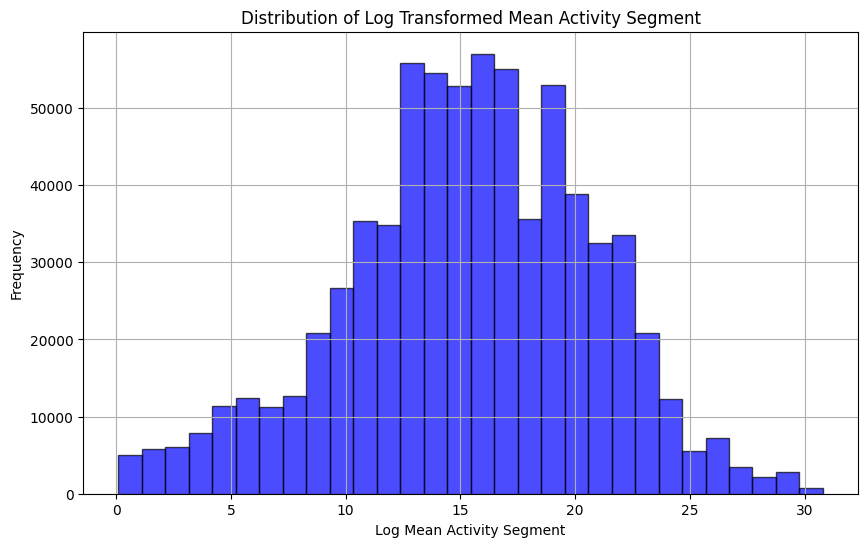

In [41]:
# Plotting the distribution of log_mean_activity_segment using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(all_control['sqrt_mean_activity_segment'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Log Transformed Mean Activity Segment')
plt.xlabel('Log Mean Activity Segment')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [34]:
all_data = pd.concat([all_condition, all_control], axis=0)
all_data

,timestamp,date,activity,minute,day,number,gender,inpatient,marriage,work,...,madrs2,avg_age,avg_edu,avg_madrs,delta_madrs,minute_segment,mean_activity_first_half,mean_activity_second_half,mean_activity_segment,log_mean_activity_segment
0,2003-05-07 12:00:00,2003-05-07,0,1,1,condition_1,2,2.0,1.0,2.0,...,19.0,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865
1,2003-05-07 12:01:00,2003-05-07,143,2,1,condition_1,2,2.0,1.0,2.0,...,19.0,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865
2,2003-05-07 12:02:00,2003-05-07,0,3,1,condition_1,2,2.0,1.0,2.0,...,19.0,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865
3,2003-05-07 12:03:00,2003-05-07,20,4,1,condition_1,2,2.0,1.0,2.0,...,19.0,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865
4,2003-05-07 12:04:00,2003-05-07,166,5,1,condition_1,2,2.0,1.0,2.0,...,19.0,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714326,2003-04-04 23:55:00,2003-04-04,0,1436,15,control_32,2,NaN,NaN,NaN,...,NaN,27,NaN,NaN,NaN,second_half,73.658333,3.159722,3.159722,1.153644
714327,2003-04-04 23:56:00,2003-04-04,0,1437,15,control_32,2,NaN,NaN,NaN,...,NaN,27,NaN,NaN,NaN,second_half,73.658333,3.159722,3.159722,1.153644
714328,2003-04-04 23:57:00,2003-04-04,0,1438,15,control_32,2,NaN,NaN,NaN,...,NaN,27,NaN,NaN,NaN,second_half,73.658333,3.159722,3.159722,1.153644
714329,2003-04-04 23:58:00,2003-04-04,0,1439,15,control_32,2,NaN,NaN,NaN,...,NaN,27,NaN,NaN,NaN,second_half,73.658333,3.159722,3.159722,1.153644


In [35]:
all_data.number.str.contains('condition')

0          True
1          True
2          True
3          True
4          True
          ...  
714326    False
714327    False
714328    False
714329    False
714330    False
Name: number, Length: 1215378, dtype: bool

In [36]:
#adding group column
all_data['group'] = all_data.groupby(all_data.number.str.contains('condition')).ngroup() + 1




In [37]:
all_data

,timestamp,date,activity,minute,day,number,gender,inpatient,marriage,work,...,avg_age,avg_edu,avg_madrs,delta_madrs,minute_segment,mean_activity_first_half,mean_activity_second_half,mean_activity_segment,log_mean_activity_segment,group
0,2003-05-07 12:00:00,2003-05-07,0,1,1,condition_1,2,2.0,1.0,2.0,...,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865,2
1,2003-05-07 12:01:00,2003-05-07,143,2,1,condition_1,2,2.0,1.0,2.0,...,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865,2
2,2003-05-07 12:02:00,2003-05-07,0,3,1,condition_1,2,2.0,1.0,2.0,...,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865,2
3,2003-05-07 12:03:00,2003-05-07,20,4,1,condition_1,2,2.0,1.0,2.0,...,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865,2
4,2003-05-07 12:04:00,2003-05-07,166,5,1,condition_1,2,2.0,1.0,2.0,...,37,8.0,19.0,0.0,first_half,262.913889,85.375000,262.913889,5.571865,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714326,2003-04-04 23:55:00,2003-04-04,0,1436,15,control_32,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,second_half,73.658333,3.159722,3.159722,1.153644,1
714327,2003-04-04 23:56:00,2003-04-04,0,1437,15,control_32,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,second_half,73.658333,3.159722,3.159722,1.153644,1
714328,2003-04-04 23:57:00,2003-04-04,0,1438,15,control_32,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,second_half,73.658333,3.159722,3.159722,1.153644,1
714329,2003-04-04 23:58:00,2003-04-04,0,1439,15,control_32,2,NaN,NaN,NaN,...,27,NaN,NaN,NaN,second_half,73.658333,3.159722,3.159722,1.153644,1


In [38]:
# Save the DataFrame as a CSV file
all_data.to_csv('all_data.csv', index=False) 